In [1]:
from data.sampler import BalancedRandomBatchGeoSampler
from configs import config
from pathlib import Path
from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, stack_samples
from data.kc import KaneCounty

naip_dataset = NAIP("/net/projects/cmap/data/KC-images")

shape_path = Path(config.KC_SHAPE_ROOT) / config.KC_SHAPE_FILENAME
dataset_config = (
        config.KC_LAYER,
        config.KC_LABELS,
        config.PATCH_SIZE,
        naip_dataset.crs,
        naip_dataset.res,
    )
kc_dataset = KaneCounty(shape_path, dataset_config)
train_dataset = naip_dataset & kc_dataset

train_sampler = BalancedRandomBatchGeoSampler(
        config={
            "dataset": train_dataset,
            "size": config.PATCH_SIZE,
            "batch_size": 1,
        }
)

plot_dataloader = DataLoader(
        dataset=train_dataset,
        batch_sampler=train_sampler,
        collate_fn=stack_samples,
        num_workers=config.NUM_WORKERS,
)


ModuleNotFoundError: No module named 'data'

In [2]:
for batch, sample in enumerate(plot_dataloader):
    print(sample['image'].shape, sample['mask'].shape)
    if batch > 2:
        break

torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])


In [3]:
def display_plot_from_tensors(sample, colors, labels, coords):
    # Call the original function with a temporary file path
    temp_path = "temp_plot.png"
    from utils.plot import plot_from_tensors
    plot_from_tensors(
        sample=sample,
        save_path=temp_path,
        colors=colors,
        labels=labels,
        coords=coords
    )
    # Now display the saved image in the notebook
    from IPython.display import Image, display
    display(Image(filename=temp_path))


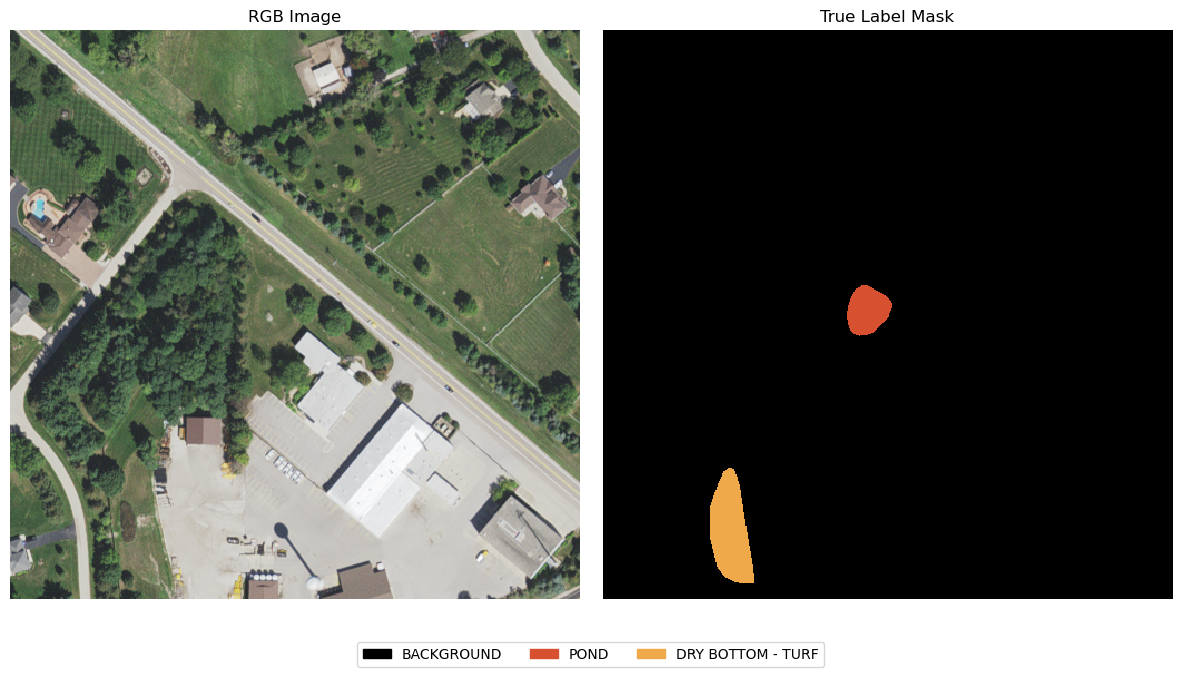

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from einops import rearrange
import torch
import numpy as np

# --- Create a custom colormap from kc_dataset.colors ---
# Sort the keys so that the colormap is consistent
sorted_keys = sorted(kc_dataset.colors.keys())
# Normalize the colors (RGB only) to [0,1]
color_list = [tuple(np.array(kc_dataset.colors[k][:3]) / 255.0) for k in sorted_keys]
custom_cmap = ListedColormap(color_list)

# --- Extract one sample from the dataloader ---
sample = next(iter(plot_dataloader))
img_tensor = sample['image'][0]  # shape: (channels, height, width)
mask_tensor = sample['mask'][0]  # shape: (height, width) or (1, height, width)

# Squeeze extra channel if necessary
if mask_tensor.dim() == 3 and mask_tensor.shape[0] == 1:
    mask_tensor = mask_tensor.squeeze(0)

# Use only the first 3 channels for RGB visualization
img_rgb = img_tensor[:3] if img_tensor.shape[0] >= 3 else img_tensor

# Rearrange the image to (height, width, channels) and convert to NumPy uint8
img_rgb_np = rearrange(img_rgb, "c h w -> h w c").cpu().numpy().astype("uint8")
# Convert mask to NumPy array for plotting
mask_np = mask_tensor.cpu().numpy()

# --- Create two subplots: RGB Image & True Label Mask ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 1. Display RGB Image (No Mask Overlay)
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].set_title("RGB Image")
axs[0].axis("off")

# 2. Display True Label Mask (solid colors, no alpha blending)
axs[1].imshow(mask_np, cmap=custom_cmap, interpolation="none", 
              vmin=0, vmax=len(sorted_keys) - 1)
axs[1].set_title("True Label Mask")
axs[1].axis("off")

# --- Create a legend for the True Label Mask ---
legend_handles = []
unique_vals_in_mask = set(np.unique(mask_np))  # Only include labels that appear in the image
for k in sorted_keys:
    if k in unique_vals_in_mask:
        label_name = kc_dataset.labels_inverse.get(k, str(k))
        color = tuple(np.array(kc_dataset.colors[k][:3]) / 255.0)
        patch = mpatches.Patch(color=color, label=label_name)
        legend_handles.append(patch)

# Add legend below the True Label Mask (only for present labels)
if legend_handles:
    fig.legend(handles=legend_handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

# Segmentation code:

In [5]:
from segment_anything import SamPredictor, sam_model_registry
import os

home_dir = os.path.expanduser("~")
sam_checkpoint = os.path.join(home_dir, "CMAP/segment-anything/sam_vit_h.pth")

sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [6]:
import torch
import numpy as np

# 1) Get unique values from the mask (excluding background=0)
unique_vals = torch.unique(mask_tensor)
valid_labels = unique_vals[unique_vals > 0]  # Exclude background (0)

if len(valid_labels) == 0:
    raise ValueError("No valid foreground labels found!")

# 2) Pick a random label from the valid set
random_label_idx = torch.randint(0, len(valid_labels), (1,)).item()
chosen_label = valid_labels[random_label_idx].item()

# 3) Gather all pixel coordinates of the chosen label
ys, xs = torch.where(mask_tensor == chosen_label)

if len(xs) > 0 and len(ys) > 0:
    # 4) Pick a random point within that label
    random_index = torch.randint(0, len(xs), (1,)).item()
    seed_x = xs[random_index].item()
    seed_y = ys[random_index].item()
    
    print(f"Selected label: {chosen_label}")
    print(f"Seed coordinate: (x={seed_x}, y={seed_y})")

    # Sanity check
    assert mask_tensor[seed_y, seed_x] == chosen_label, \
        "Seed point not inside the chosen label!"
else:
    raise ValueError("No valid pixel found for chosen label!")

Selected label: 1
Seed coordinate: (x=248, y=241)


Using  segmentation seed coordinate: (x=248, y=241)


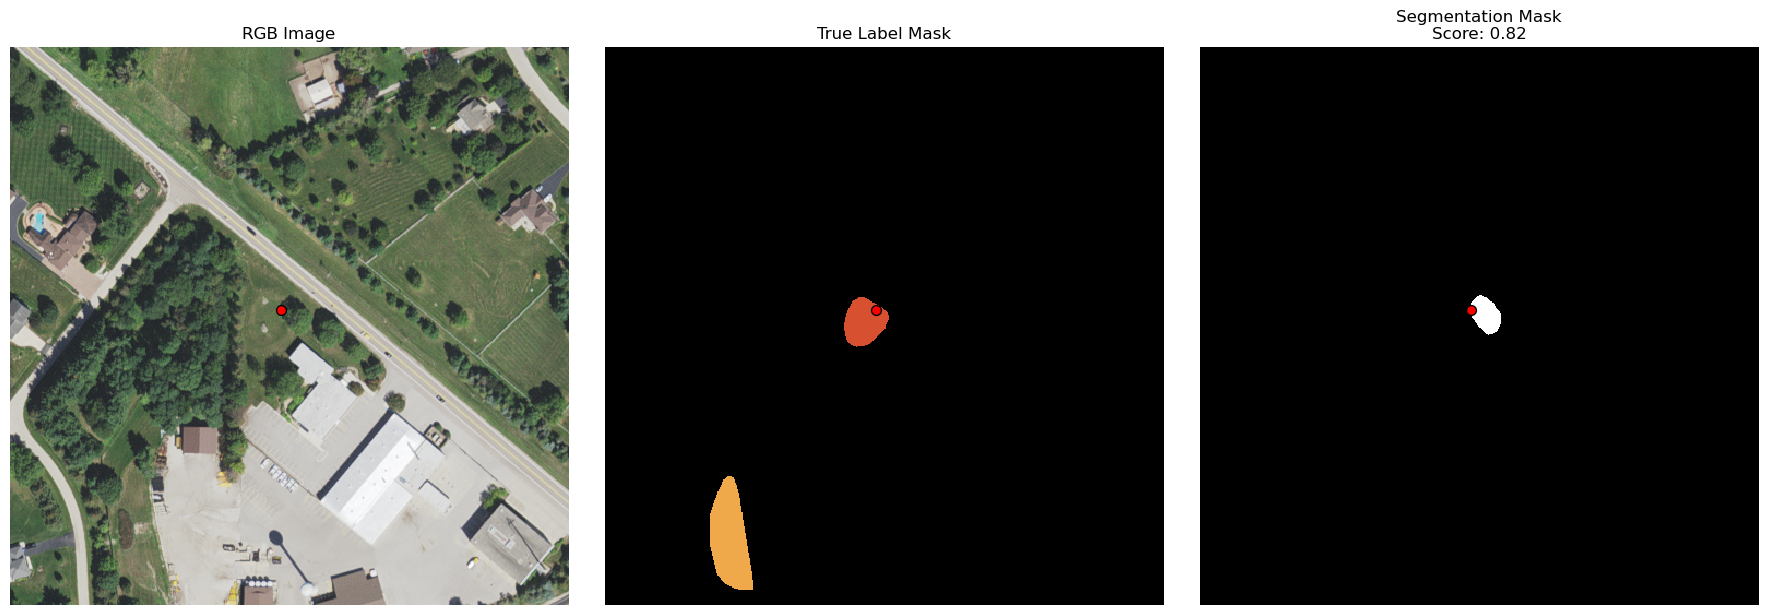

Saved segmentation result to: /home/gregoryc25/CMAP/segment-anything/kc-sam-outputs


In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# Ensure we're using the same stored seed point
print(f"Using  segmentation seed coordinate: (x={seed_x}, y={seed_y})")

# Create the seed coordinate array in the expected shape (1, 2)
seed_coordinate = np.array([[seed_x, seed_y]])
seed_label = np.array([1])  # Positive prompt

# Set the image before predicting
predictor.set_image(img_rgb_np)

# --- Call the SAM predictor with the **same seed** ---
masks, scores, logits = predictor.predict(
    point_coords=seed_coordinate,
    point_labels=seed_label,
    multimask_output=False  # Single best mask
)

# Select the **highest scoring mask**
best_mask = masks[0]
best_score = scores[0]

# --- Create Three Subplots: RGB, True Label Mask, Segmentation Mask ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Display RGB Image with Seed Point
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[0].set_title("RGB Image")
axs[0].axis("off")

# 2. Display True Label Mask with Seed Point (Solid Colors)
axs[1].imshow(mask_np, cmap=custom_cmap, interpolation="none", vmin=0, vmax=len(sorted_keys) - 1)
axs[1].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[1].set_title("True Label Mask")
axs[1].axis("off")

# 3. Display Best Segmentation Mask with Seed Point
axs[2].imshow(best_mask, cmap="gray", interpolation="none")
axs[2].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[2].set_title(f"Segmentation Mask\nScore: {best_score:.2f}")
axs[2].axis("off")

# Define the output directory
output_folder = os.path.join(home_dir, "CMAP/segment-anything/kc-sam-outputs")

# Ensure the folder exists
os.makedirs(output_folder, exist_ok=True)

# Generate a unique filename (timestamp-based)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(output_folder, f"segmentation_{timestamp}.png")

# Save the figure
plt.savefig(output_path, bbox_inches="tight", dpi=300)

plt.tight_layout()
plt.show()

print(f"Saved segmentation result to: {output_folder}")

# Metric calculations

In [8]:
# ================================
# Cell: Per-class & Instance IoU
# ================================
import numpy as np

def compute_iou_per_class(pred_mask, gt_mask, num_classes):
    """
    Calculate per-class IoU for a single predicted mask vs. a single ground-truth mask.
      pred_mask, gt_mask : same shape, integer-labeled
      num_classes        : total number of classes
    Returns: {class_id: iou_value}
    """
    iou_dict = {}
    for cls_id in range(num_classes):
        pred_cls = (pred_mask == cls_id).astype(np.uint8)
        gt_cls   = (gt_mask == cls_id).astype(np.uint8)
        
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union        = np.logical_or(pred_cls, gt_cls).sum()
        
        iou_dict[cls_id] = (intersection / union) if union else 0.0
    return iou_dict

def compute_instance_iou(pred_mask, gt_mask, instance_id):
    """
    Calculate IoU for a *single ground-truth instance* vs. predicted mask.
      pred_mask, gt_mask: same shape (binary or instance-labeled)
      instance_id       : the ground-truth label ID we care about
    Returns: IoU (float)
    """
    # Extract the ground-truth region for 'instance_id'
    gt_instance = (gt_mask == instance_id).astype(np.uint8)
    
    # If your prediction is binary (foreground=1, background=0), do (pred_mask > 0).
    # If you have instance-labeled predictions, do (pred_mask == instance_id) instead.
    pred_instance = (pred_mask > 0).astype(np.uint8)
    
    intersection = np.logical_and(gt_instance, pred_instance).sum()
    union        = np.logical_or(gt_instance, pred_instance).sum()
    
    return float(intersection) / union if union else 0.0

# ------------------------------------------
# Example usage with your existing variables
# ------------------------------------------
# best_mask     -> Your predicted mask as a NumPy array
# mask_np       -> Your ground-truth mask as a NumPy array
# chosen_label  -> The label ID of the polygon/instance we care about
# num_classes   -> Number of classes if you want per-class IoU

# 1) Instance IoU
iou_instance = compute_instance_iou(best_mask, mask_np, chosen_label)
print(f"Instance {chosen_label} IoU: {iou_instance:.4f}")

# 2) (Optional) Per-class IoU
# if 'num_classes' in globals():
#     iou_classes = compute_iou_per_class(best_mask, mask_np, num_classes)
#     print("Per-class IoU:")
#     for cls_id, iou_val in iou_classes.items():
#         print(f"  Class {cls_id}: {iou_val:.4f}")


Instance 1 IoU: 0.0799


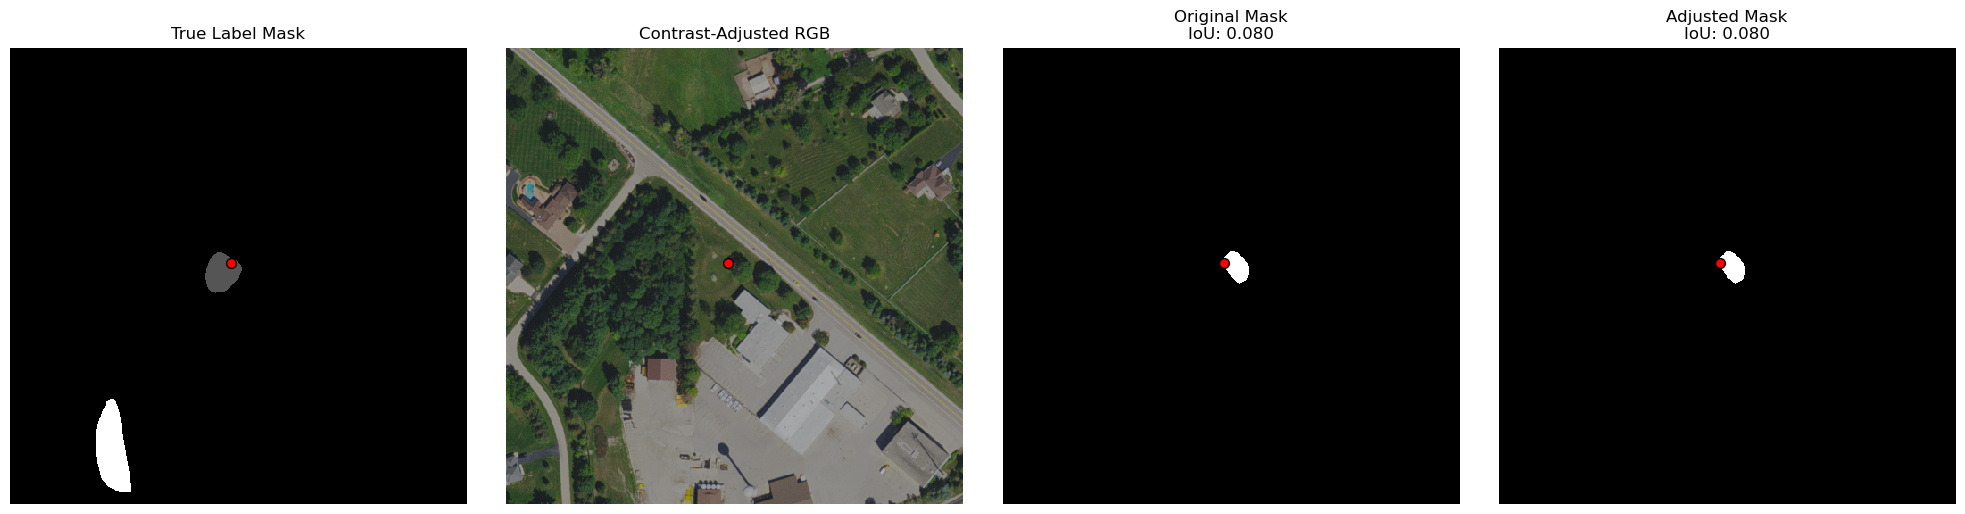

Original IoU (label=1): 0.0799
Adjusted IoU (label=1): 0.0804


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Define or reuse the contrast-adjustment function
def adjust_contrast(image, factor=0.8):
    """
    Decrease or increase the contrast of an image by 'factor'.
    factor < 1.0 -> reduce contrast (helpful if shadows are harsh)
    factor > 1.0 -> increase contrast
    """
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = np.clip(l * factor, 0, 255).astype(np.uint8)
    adjusted_lab = cv2.merge((l, a, b))
    adjusted_image = cv2.cvtColor(adjusted_lab, cv2.COLOR_LAB2BGR)
    return adjusted_image

# 2) Create a contrast-adjusted version of the original image
adjusted_img = adjust_contrast(img_rgb_np, factor=0.7)

# 3) Run the SAM predictor on the *original* image using the same seed
predictor.set_image(img_rgb_np)
masks_orig, scores_orig, _ = predictor.predict(
    point_coords=seed_coordinate,
    point_labels=seed_label,
    multimask_output=False
)
best_mask_orig = masks_orig[0]  # binary mask
score_orig = scores_orig[0]

# 4) Run the SAM predictor on the *contrast-adjusted* image using the same seed
predictor.set_image(adjusted_img)
masks_adj, scores_adj, _ = predictor.predict(
    point_coords=seed_coordinate,
    point_labels=seed_label,
    multimask_output=False
)
best_mask_adj = masks_adj[0]  # binary mask
score_adj = scores_adj[0]

# 5) Convert both predicted masks to np.uint8 for IoU
pred_mask_orig = best_mask_orig.astype(np.uint8)
pred_mask_adj  = best_mask_adj.astype(np.uint8)

# 6) Compute IoU for each
iou_orig = compute_instance_iou(pred_mask_orig, mask_np, chosen_label)
iou_adj  = compute_instance_iou(pred_mask_adj,  mask_np, chosen_label)

# 7) Show four subplots:
#    (1) True Label Mask + seed
#    (2) Contrast-Adjusted RGB + seed
#    (3) Original Seg Mask + IoU
#    (4) Contrast-Adjusted Seg Mask + IoU

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# (1) True Label Mask
axs[0].imshow(mask_np, cmap="gray", interpolation="none")
axs[0].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[0].set_title("True Label Mask")
axs[0].axis("off")

# (2) Contrast-Adjusted RGB
axs[1].imshow(adjusted_img, interpolation="none")
axs[1].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[1].set_title("Contrast-Adjusted RGB")
axs[1].axis("off")

# (3) Original Segmentation Mask
axs[2].imshow(best_mask_orig, cmap="gray", interpolation="none")
axs[2].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[2].set_title(f"Original Mask\nIoU: {iou_orig:.3f}")
axs[2].axis("off")

# (4) Contrast-Adjusted Segmentation Mask
axs[3].imshow(best_mask_adj, cmap="gray", interpolation="none")
axs[3].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[3].set_title(f"Adjusted Mask\nIoU: {iou_adj:.3f}")
axs[3].axis("off")

plt.tight_layout()
plt.show()

print(f"Original IoU (label={chosen_label}): {iou_orig:.4f}")
print(f"Adjusted IoU (label={chosen_label}): {iou_adj:.4f}")
